In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy as d_copy
import random

In [2]:
folderpath = "/media/3/Network/filter/pooling4/case11/F4F_weight"
files = sorted(os.listdir("/media/3/Network/filter/pooling4/case11/F4F_weight"))
files

['F4F_bias_fc1_train_epoch_001.pt',
 'F4F_bias_fc1_train_epoch_002.pt',
 'F4F_bias_fc1_train_epoch_003.pt',
 'F4F_bias_fc1_train_epoch_004.pt',
 'F4F_bias_fc1_train_epoch_005.pt',
 'F4F_bias_fc1_train_epoch_006.pt',
 'F4F_bias_fc1_train_epoch_007.pt',
 'F4F_bias_fc1_train_epoch_008.pt',
 'F4F_bias_fc1_train_epoch_009.pt',
 'F4F_bias_fc1_train_epoch_010.pt',
 'F4F_bias_fc1_train_epoch_011.pt',
 'F4F_bias_fc1_train_epoch_012.pt',
 'F4F_bias_fc1_train_epoch_013.pt',
 'F4F_bias_fc1_train_epoch_014.pt',
 'F4F_bias_fc1_train_epoch_015.pt',
 'F4F_bias_fc1_train_epoch_016.pt',
 'F4F_bias_fc1_train_epoch_017.pt',
 'F4F_bias_fc1_train_epoch_018.pt',
 'F4F_bias_fc1_train_epoch_019.pt',
 'F4F_bias_fc1_train_epoch_020.pt',
 'F4F_bias_fc1_train_epoch_021.pt',
 'F4F_bias_fc2_train_epoch_001.pt',
 'F4F_bias_fc2_train_epoch_002.pt',
 'F4F_bias_fc2_train_epoch_003.pt',
 'F4F_bias_fc2_train_epoch_004.pt',
 'F4F_bias_fc2_train_epoch_005.pt',
 'F4F_bias_fc2_train_epoch_006.pt',
 'F4F_bias_fc2_train_epoch_0

In [34]:
!ls /media/3/Network/filter/pooling4/case11/only_error_input_F4F/conv5_1_train_epoch_021.pt
#  /media/3/Network/filter/pooling4/conv5_1_original.pt : original filter
# /media/3/Network/filter/pooling4/case11/only_error_input_F4F : offset + original

conv5_1_train_epoch_001.pt  conv5_1_train_epoch_012.pt
conv5_1_train_epoch_002.pt  conv5_1_train_epoch_013.pt
conv5_1_train_epoch_003.pt  conv5_1_train_epoch_014.pt
conv5_1_train_epoch_004.pt  conv5_1_train_epoch_015.pt
conv5_1_train_epoch_005.pt  conv5_1_train_epoch_016.pt
conv5_1_train_epoch_006.pt  conv5_1_train_epoch_017.pt
conv5_1_train_epoch_007.pt  conv5_1_train_epoch_018.pt
conv5_1_train_epoch_008.pt  conv5_1_train_epoch_019.pt
conv5_1_train_epoch_009.pt  conv5_1_train_epoch_020.pt
conv5_1_train_epoch_010.pt  conv5_1_train_epoch_021.pt
conv5_1_train_epoch_011.pt


In [3]:
fc1_weight = []
fc1_bias = []
fc2_weight = []
fc2_bias = []
fc3_weight = []
fc3_bias = []
for idx,item in enumerate(files):
    if "bias_fc1" in item:
        #tmp = os.path.join(folderpath,item)
        fc1_bias.append(item)
    elif "bias_fc2" in item:
        fc2_bias.append(item)
    elif "bias_fc3" in item:
        fc3_bias.append(item)
    elif "weight_fc1" in item:
        fc1_weight.append(item)
    elif "weight_fc2" in item:
        fc2_weight.append(item)
    elif "weight_fc3" in item:
        fc3_weight.append(item)
    

In [4]:
len(fc1_weight), len(fc1_bias)

(21, 21)

In [10]:
fc1_weight_21 = torch.load( os.path.join(folderpath,fc1_weight[20]) ).cpu().detach().numpy()
fc2_weight_21 = torch.load( os.path.join(folderpath,fc2_weight[20]) ).cpu().detach().numpy()
fc3_weight_21 = torch.load( os.path.join(folderpath,fc3_weight[20]) ).cpu().detach().numpy()

In [ ]:
original_filter_path = "/media/3/Network/filter/pooling4/conv5_1_original.pt"
new_filter_path = "/media/3/Network/filter/pooling4/case11/only_error_input_F4F/conv5_1_train_epoch_021.pt"
new_filter = torch.load(new_filter_path).cpu().detach().numpy()
original_filter = torch.load(original_filter_path).cpu().detach().numpy()

In [83]:
new_filter.shape,original_filter.shape

NameError: name 'new_filter' is not defined

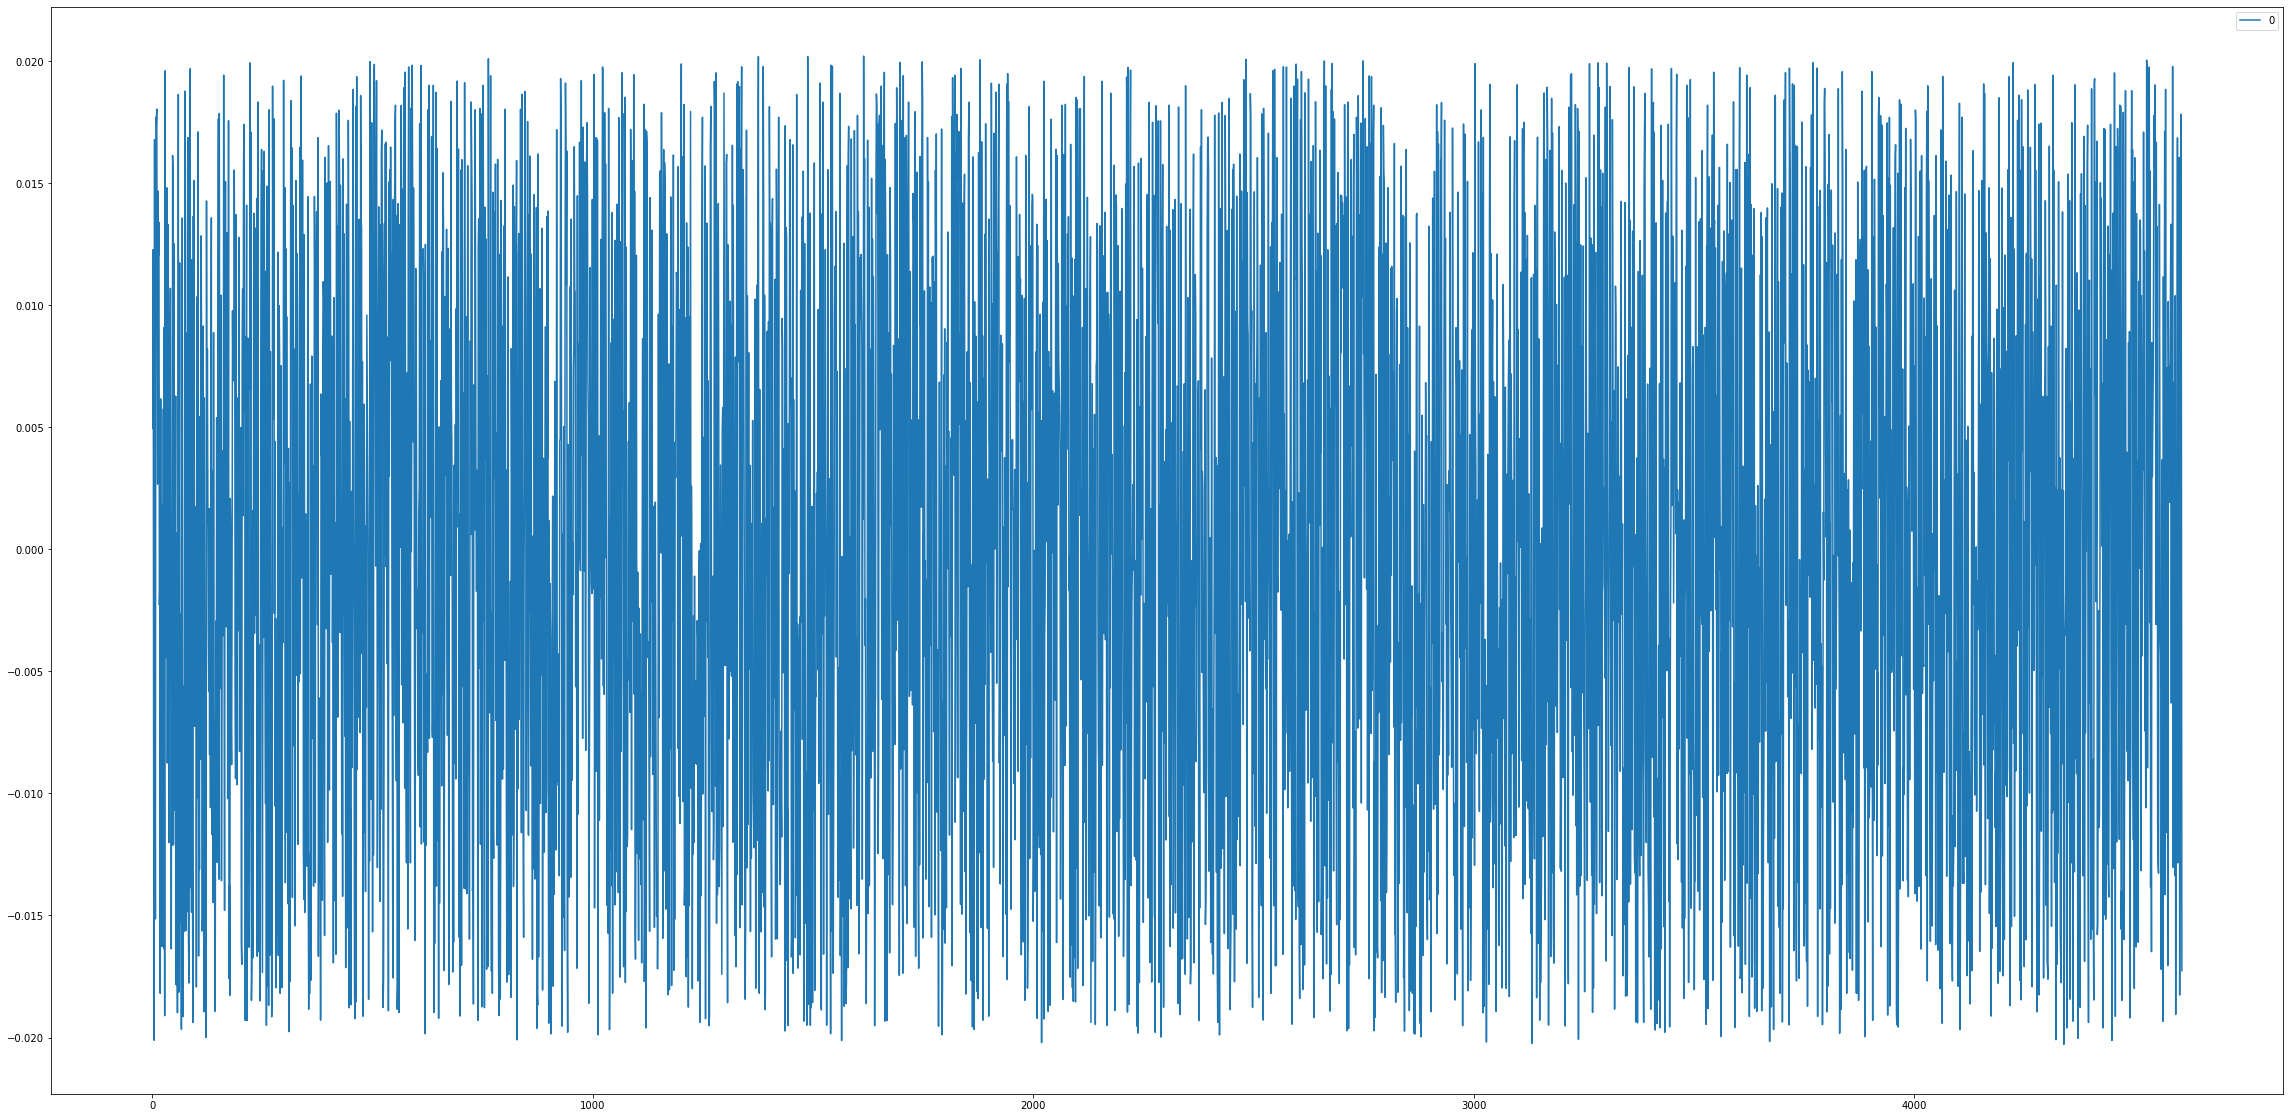

In [28]:
%matplotlib inline
#fig = plt.figure()
plt.figure(figsize=(40,20))
x = range(1,len(fc3_weight_21)+1)
plt.plot(x,fc3_weight_21[:,0],label='0')
#plt.plot(x,fc1_weight_21[:,1],label='1')
#plt.plot(x,fc1_weight_21[:,2],label='2')
#plt.plot(x,fc1_weight_21[:,3],label='3')
plt.legend(loc='best')
plt.show()

In [67]:
def set_randomness(seed=0):
    #torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #np.random.seed(seed)
    random.seed(seed)

In [87]:
# set randomness
seed = 0

set_randomness(seed) # ipynb module import means run all cell in file
# load dataset
dataset_path = "/media/2/Network/Imagenet_dup/"
retrain_model_path = "/media/0/Network/0821_to_fullmodels/"
batch_size = 32 # 32~ out of memory in 3080
num_train = 128000 #640000
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transforms_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
test_dataset = dataset.ImageFolder(root=dataset_path+"val",
                                       transform=transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=1)
len(test_dataloader)
# dataset -> class에 대해서 같은 error_index

1563

In [88]:
for idx,item in enumerate(test_dataloader):
    if 0 in item[1]:
        print(idx,item[1])

0 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
1 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [84]:
if 0 in item[1]:
    print("true")

In [ ]:
"""
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5])
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5])
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 7, 7])
"""